# Univariate Statistical analyses and heatmap
**Author**: F Ottosson (faot@ssi.dk), M Ernst (maet@ssi.dk) <br>
Last update: August 24, 2023

In this notebook we will perform a nonparametric Friedman test to assess whether there are metabolites statistically significantly differentially abundant across different timepoints. We then visualize normalized and scaled relative abundances of the statistically significant metabolites in different sample types in a heatmap.

**Data**

Non-invasive drug monitoring is desirable as it improves patient experience. Instead of relying on invasive blood draws drug pharmacokinetics and metabolism could for example be monitored through the skin. In this tutorial we will be working with a subset of the data published by [Panitchpakdi and collaborators (2022)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0271794). The datasets consists of plasma and skin swabs (forearm, forehead and upper back) collected from healthy volunteers (n=7) over the course of 24 hours, who have been administered the antihistaminic diphenhydramine.


**Questions**

We will explore whether there are differences in blood and skin metabolites across different time points. The analyses will be performed using a Friedman test by ranks, given the lack of normality in metabolomics datasets and repeated sampling of participants.

## Install and import packages needed for analyses

In [1]:
install.packages("ggplot2")
install.packages("ggsci")
install.packages("cowplot")
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’




In [2]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("ComplexHeatmap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Installing package(s) 'BiocVersion', 'ComplexHeatmap'

also installing the dependencies ‘shape’, ‘rjson’, ‘BiocGenerics’, ‘S4Vectors’, ‘iterators’, ‘circlize’, ‘GetoptLong’, ‘clue’, ‘GlobalOptions’, ‘png’, ‘IRanges’, ‘matrixStats’, ‘foreach’, ‘doParallel’


Old packages: 'bit', 'bslib', 'curl', 'devtools', 'fontawesome', 'gargle',
  'ggplot2', 'gtable', 'highr', 'httr', 'isoband', 'openssl', 'rmarkdown',
  'roxygen2', 'uuid', 'whisker', 'boot', 'foreign', 'Matrix', 'nlme',
  'survival'



In [3]:
suppressPackageStartupMessages({
library(ggplot2)
library(ggsci)
library(cowplot)
library(ggrepel)
library(ComplexHeatmap)
})

## Import datasets from github

In [4]:
## feature table
ft_url <- 'https://raw.githubusercontent.com/ssi-dk/CD-MRG-metabolomics_summerschool_2023/main/data/datacleanup_output/Example/Imputed_scaled_table.csv'
## metadata
md_url <- 'https://raw.githubusercontent.com/ssi-dk/CD-MRG-metabolomics_summerschool_2023/main/data/metadata/metadata.txt'

In [5]:
ft <- read.csv(ft_url)
md <- read.csv(md_url,sep="\t")

Explore structure of feature table and metadata

In [6]:
head(ft)
head(md)

,X,X9002_150.063_4.963,X8808_150.596_4.822,X4094_151.039_3.305,X2584_151.039_2.783,X5788_151.075_3.796,X5122_151.075_3.587,X598_151.075_1.534,X1334_151.075_2.335,X649_151.075_1.623,⋯,X14653_1257.898_7.839,X7262_1259.35_4.281,X7209_1259.493_4.282,X7274_1259.638_4.269,X14656_1280.974_7.835,X14686_1310.987_8.01,X14690_1315.94_8.014,X14715_1369.027_8.219,X14730_1427.068_8.446,X7267_1469.075_4.282
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,bld_plt1_01_0_1.mzML,-0.8662273,-0.1965295,-0.8831492,-0.9477855,-0.9476314,-0.8827588,-0.7154505,-0.9454694,-0.6376003,⋯,-0.2132227,-0.3324730,-0.3033492,-0.2627040,-0.1705409,-0.2348066,-0.1877471,-0.1946509,-0.1756857,-0.1351521
2,bld_plt1_01_120_1.mzML,-0.8662301,-0.1973397,-0.8831492,-0.9491684,-0.9526049,-0.8824262,-0.7153539,-0.9458006,-0.6373360,⋯,-0.2122461,0.6185309,0.8157820,0.7605538,-0.1698431,-0.2347819,-0.1866834,-0.1943536,-0.1752368,0.5971932
3,bld_plt1_01_600_1.mzML,-0.8660764,-0.1976290,-0.8829391,-0.9503707,-0.9040143,-0.8799596,-0.7155218,-0.9447739,-0.6376531,⋯,-0.2122461,-0.1593889,-0.2756309,-0.1761300,-0.1709513,-0.2344228,-0.1870616,-0.1940105,-0.1746247,-0.2178643
4,bld_plt1_01_720_1.mzML,-0.8661837,-0.1971660,-0.8830250,-0.9500788,-0.8552687,-0.8825044,-0.7149378,-0.9445606,-0.6364170,⋯,-0.2135483,-0.3771775,-0.3600902,-0.3422496,-0.1704588,-0.2343237,-0.1870852,-0.1947881,-0.1753185,-0.2387165
5,bld_plt1_03_0_1.mzML,-0.8662304,-0.1961822,-0.8830441,-0.9492972,-0.5652369,-0.8825925,-0.7153917,-0.9452463,-0.6374285,⋯,-0.2121277,-0.3358358,-0.3152846,-0.3367929,-0.1707461,-0.2343485,-0.1873925,-0.1944451,-0.1762979,-0.2613841
6,bld_plt1_03_480_1.mzML,-0.8662304,-0.1954299,-0.8831205,-0.9490195,-0.5554838,-0.8826121,-0.7153833,-0.9458308,-0.6377721,⋯,-0.2129860,-0.3665276,-0.3596632,-0.3417601,-0.1693095,-0.2345466,-0.1876289,-0.1946738,-0.1745431,-0.2712681


,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Subject,ATTRIBUTE_Timepoint_min,ATTRIBUTE_Sampling_Location,ATTRIBUTE_Analysis_order
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,bld_plt1_01_0_1.mzML,plasma,Subject_1,0,not applicable,19
2,bld_plt1_01_120_1.mzML,plasma,Subject_1,120,not applicable,32
3,bld_plt1_01_600_1.mzML,plasma,Subject_1,600,not applicable,51
4,bld_plt1_01_720_1.mzML,plasma,Subject_1,720,not applicable,50
5,bld_plt1_03_0_1.mzML,plasma,Subject_3,0,not applicable,20
6,bld_plt1_03_480_1.mzML,plasma,Subject_3,480,not applicable,52


Feature table and metadata is merged to one data frame. Column that give the filename can be used to merge the datasets but they have different names.

In [7]:
Data <- merge(md,ft,by.x="filename",by.y="X")

Check that merging was successfull. We should make sure that the number of columns in the new dataframe *Data* is equal to the sum of columns in ft and md minus one

In [8]:
dim(ft)
dim(md)
dim(Data)

[1]   84 5570

[1] 172   6

[1]   84 5575

In [9]:
Data[1:5,1:8]

,filename,ATTRIBUTE_Sample_Type,ATTRIBUTE_Subject,ATTRIBUTE_Timepoint_min,ATTRIBUTE_Sampling_Location,ATTRIBUTE_Analysis_order,X9002_150.063_4.963,X8808_150.596_4.822
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,bld_plt1_01_0_1.mzML,plasma,Subject_1,0,not applicable,19,-0.8662273,-0.1965295
2,bld_plt1_01_120_1.mzML,plasma,Subject_1,120,not applicable,32,-0.8662301,-0.1973397
3,bld_plt1_01_600_1.mzML,plasma,Subject_1,600,not applicable,51,-0.8660764,-0.1976290
4,bld_plt1_01_720_1.mzML,plasma,Subject_1,720,not applicable,50,-0.8661837,-0.1971660
5,bld_plt1_03_0_1.mzML,plasma,Subject_3,0,not applicable,20,-0.8662304,-0.1961822


# Run Friedman test analyses in plasma samples
Test if there are associations between the plasma metabolome and time after administration of drug. Given that we expect a significant number of metabolite features not to be normally distributed, we use a non-parametric test. [Friedman test](https://en.wikipedia.org/wiki/Friedman_test) is a non-parametric version of repeated measurements [ANOVA](https://https://en.wikipedia.org/wiki/Analysis_of_variance). The Friedman test is implemented in R using the function [*friedman.test*](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/friedman.test).

We will perform one Friedman test for each metabolite feature in the dataset. We can define the first column containing metabolite data to be used in the analyses below:

In [10]:
start <- which(names(Data)=="ATTRIBUTE_Analysis_order")+1

We create a subset dataset containing only plasma samples

In [11]:
Data_plasma <- subset(Data,ATTRIBUTE_Sample_Type=="plasma")

We create a dataframe for the Friedman tests output called *ouput_plasma*. We populate it with the following coulmns:


*   **Metabolite**: The metabolite names as given in the dataset
*   **p**: These are the p-values from the Friedman tests analyses. We calculate these by running one *friedman.test* per metabolite feature: friedman.test(Data_plasma[,n]~Data_plasma$ATTRIBUTE_Timepoint_min), where Data_plasma[,n] indicates the nth column in the dataset. The function [*sapply*](https://www.rdocumentation.org/packages/memisc/versions/0.99.31.6/topics/Sapply) can be used to vary n between the first and last metabolite column. This is given by the first input argument *start:nrow(output_plasma)* where *start* is the first metabolite column as defined above. The second input argument is the *friedman.test* method given above.
* **p_fdr**: are the false discovery rate-adjusted p-values. Since we perform one statistical test per metabolite feature, using a p-values threshold of p<0.05 will provide many false positives. This can be adjusted for by keeping the false discovery rate constant using the [*p.adjust*](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/p.adjust) function.
* **Significant**: This column simply indiciates whether *p_fdr* is below 0.05 or not.
* **mz**: We can plot the p-values versus the m/z. These can be extracted from the dataset column names (Metabolite column) using [*strsplit*](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/strsplit).




In [12]:
output_plasma <- data.frame(colnames(Data_plasma[start:ncol(Data_plasma)]))
colnames(output_plasma) <- "Metabolite"
output_plasma$p <- sapply(start:ncol(Data_plasma),function(n){friedman.test(Data_plasma[,n]~ATTRIBUTE_Timepoint_min|ATTRIBUTE_Subject,data=Data_plasma)$p.value})
output_plasma$p_fdr <- p.adjust(output_plasma$p,method = "fdr")

In [13]:
output_plasma$significant <- ifelse(output_plasma$p_fdr<0.05,"Significant","Nonsignificant")
output_plasma$mz <- as.numeric(as.character(sapply(1:nrow(output_plasma),
                                                   function(n){strsplit(as.character(output_plasma$Metabolite),"_")[[n]][2]})))

**Show the strongest associations in a table**

In [14]:
head(output_plasma[order(output_plasma$p),],n=20)

,Metabolite,p,p_fdr,significant,mz
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
124,X7321_167.086_4.289,4.620422e-06,0.01356311,Significant,167.086
3624,X3752_418.223_3.177,5.777685e-06,0.01356311,Significant,418.223
1580,X4973_272.165_3.547,9.721377e-06,0.01356311,Significant,272.165
3771,X3770_432.202_3.182,1.086553e-05,0.01356311,Significant,432.202
3909,X2566_448.197_2.789,1.357024e-05,0.01356311,Significant,448.197
1421,X7317_265.084_4.289,1.461279e-05,0.01356311,Significant,265.084
125,X4509_167.086_3.404,1.892821e-05,0.01505874,Significant,167.086
1301,X4511_256.17_3.408,2.276396e-05,0.01584656,Significant,256.170
2344,X10707_315.253_5.722,4.413639e-05,0.02731062,Significant,315.253


**Plot p-values and m/z**

We can plot our results using the package [*ggplot2*](https://ggplot2.tidyverse.org/).

In [15]:
friedman_plot <- ggplot(output_plasma,aes(y=-log(p,base=10),x=mz,color=significant))+
geom_point(aes(alpha = -log(p)), size = 3) +  # Use alpha aesthetic for gradient
theme_minimal()+
xlab("m/z")+
ylab("-log(p)")+
scale_x_continuous(limits = c(50,1000))+
scale_color_jama()+
geom_text_repel(data=subset(output_plasma,p_fdr<0.05),aes(label=mz))+
theme(legend.position = "none")

Warning message:
“Removed 35 rows containing missing values (`geom_point()`).”


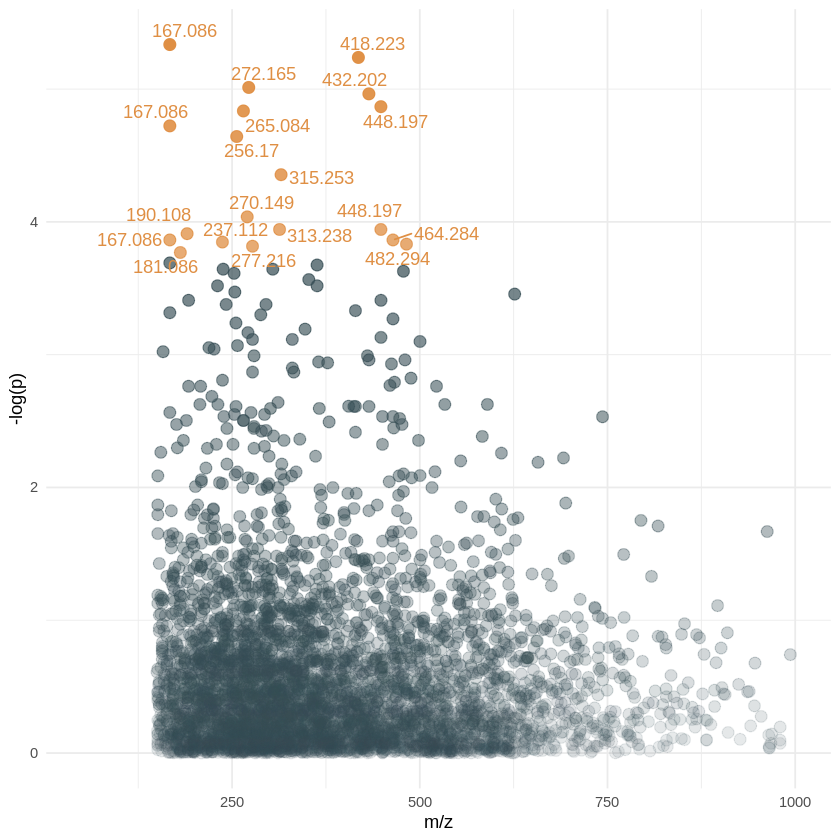

In [16]:
friedman_plot

**Export plot as .pdf**

We might want to inspect the plot in more detail outisde of Colab and could export it as a pdf-file. One way to do this is to use the ggplot2 function [*ggsave*](https://ggplot2.tidyverse.org/reference/ggsave.html).

In [17]:
ggsave("plot_friedman_p.pdf",friedman_plot,width=12,height=6)

Warning message:
“Removed 35 rows containing missing values (`geom_point()`).”


## Inspect significant features in skin samples

Here we create a subset dataset with only metabolites with significant p-values from the Friedman test. These features can be further analyzed using Friedman tests in the skin samples to find if any of the metabolite features that were altered in plasma have significant differences also in the skin.

In [18]:
significant_features <- as.character(subset(output_plasma[order(output_plasma$p),],p_fdr<0.05)[,1])
Data_significant <- Data[colnames(Data) %in% c(names(Data)[1:(start-1)],significant_features)]

Perform Kruskall Wallis analyses for significant plasma metabolites in skin samples in order to find metabolites that are also changed in skin samples after drug administration

In [19]:
Data_skin <- subset(Data_significant,ATTRIBUTE_Sample_Type=="skin")

In [20]:
output_skin <- data.frame(colnames(Data_skin[start:ncol(Data_skin)]))
colnames(output_skin) <- "Metabolite"
output_skin$p <- sapply(start:ncol(Data_skin),function(n){friedman.test(Data_skin[,n]~ATTRIBUTE_Timepoint_min|ATTRIBUTE_Subject,data=Data_skin)$p.value})
output_skin$p_fdr <- p.adjust(output_skin$p,method = "fdr")

**Display the findings in a table**

In [21]:
head(output_skin[order(output_skin$p),],n=20)

,Metabolite,p,p_fdr
,<chr>,<dbl>,<dbl>
7,X4511_256.17_3.408,4.555582e-06,8.655606e-05
2,X4509_167.086_3.404,1.408194e-05,1.337784e-04
11,X7994_277.216_4.514,6.671432e-03,4.225240e-02
15,X3770_432.202_3.182,2.513598e-02,1.015574e-01
14,X3752_418.223_3.177,2.672563e-02,1.015574e-01
19,X6220_482.294_3.982,1.011957e-01,2.987044e-01
3,X3930_167.086_3.325,1.100490e-01,2.987044e-01
8,X7317_265.084_4.289,1.522166e-01,3.615144e-01
18,X6416_464.284_3.965,1.738366e-01,3.669883e-01


Were there any feautes that also were significant in the skin samples?

## Explore timetrends in both plasma and skin sample

We have shown whether metabolites are differentially abundant in plasma and skin up to 12 hours after administration of diphenhydramine. We have however not shown which timepoints differ and how the levels are changing over time. We can plot this for all metabolites that had significant differences in plasma.

Create a subset dataset including only metabolites that were significant in plasma.

In [22]:
Data_significant <- Data[,c(names(Data[,1:(start-1)]),significant_features), drop = FALSE]

In [23]:
Data_significant <- subset(Data_significant,ATTRIBUTE_Sample_Type=="plasma"|ATTRIBUTE_Sample_Type=="skin")
Data_significant$ATTRIBUTE_Timepoint_min <- as.numeric(as.character(Data_significant$ATTRIBUTE_Timepoint_min))

**Create a plot for each metabolite**

Visualize how levels of the significant metabolites change over time in both plasma and skin samples using ggplot2. We can create a list (*plots_list*), where each entry contains the plot for one metabolite. The list is created by looping over all metabolite columns in *Data_significant* (given by *start:ncol(Data_signficant*). We can create a scatterplot with all individual metabolite levels across the different timepoints and also include a timetrend shown as a curve. The curve is created using the ggplot function [*geom_smooth*](https://ggplot2.tidyverse.org/reference/geom_smooth.html), we several different smoothing methods can be used. Here we use local estimated scatterplot smoothing ([*LOESS*](https://en.wikipedia.org/wiki/Local_regression)).

In [24]:
plots_list <- list()

for (i in start:ncol(Data_significant)) {

    plots_list[[(i-start)+1]] <- ggplot(Data_significant, aes(x = ATTRIBUTE_Timepoint_min,
                                                    y = .data[[names(Data_significant)[i]]],
                                                    color = ATTRIBUTE_Sample_Type,
                                                    group = ATTRIBUTE_Sample_Type,
                                                    fill = ATTRIBUTE_Sample_Type)) +
        geom_point(size = 1, alpha = 0.5) +
        theme_minimal() +
        geom_smooth(method = "loess") +
        ggtitle(paste("Time trend for", names(Data_significant)[i])) +
        xlab("Time (minutes)") +
        ylab("Peak Area") +
        theme(legend.position = "none") +
        scale_x_continuous(breaks = c(0, 120, 240, 480, 600, 720))
}

**Display timetrends for metabolites significant in skin samples**

If there were any signficant findings in the skin samples, we could start by inspecting these features timetrends

In [25]:
significant_features_skin <- as.character(subset(output_skin,p_fdr<0.05)[,1])

In [26]:
significant_features_skin

[1] "X4509_167.086_3.404" "X4511_256.17_3.408"  "X7994_277.216_4.514"

Display the most significant potential skin biomarker. If there were more than one significant features you want to display, change *potential_biomarkers[[1]]* to *potential_biomarkers[[2]]* or *potential_biomarkers[[n]]*...

`geom_smooth()` using formula = 'y ~ x'


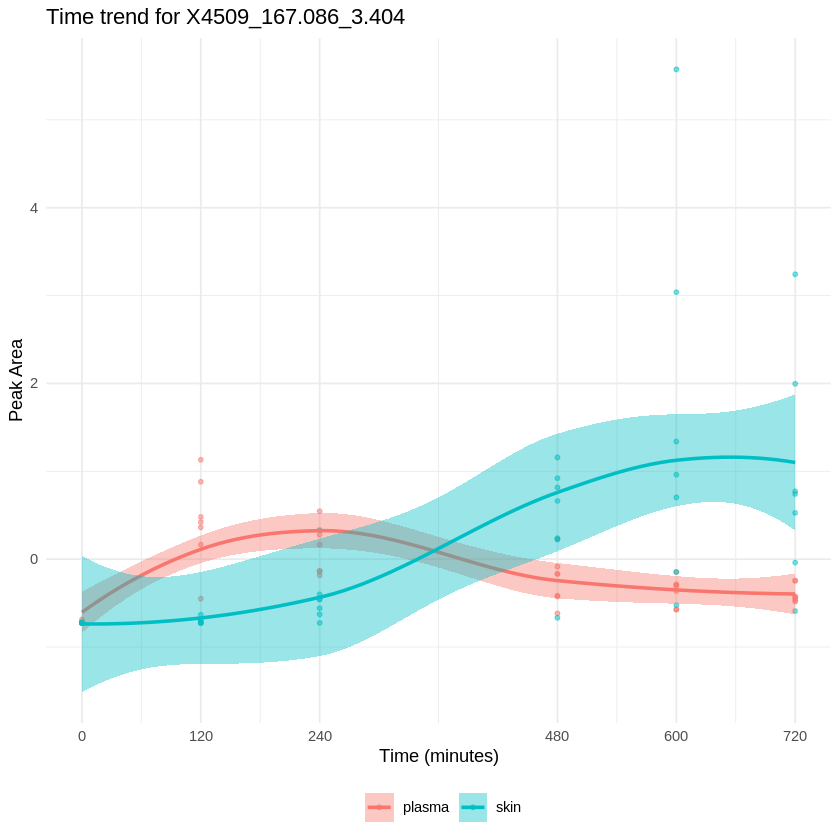

In [27]:
potential_biomarkers <- which(names(Data_significant) %in% significant_features_skin)-start+1

plots_list[[potential_biomarkers[1]]]+theme(legend.position = "bottom",legend.title = element_blank())

**Export plots for all significant features**

It might also be interesting to look at features that were only significant in plasma but not skin. We plot time trends for all metabolites that were significantly different in plasma samples. How do the timetrends look in skin samples?

We can fit four metabolites into one plot. This way, we both reduce the number of files we export and also make it easier to compare different metabolites timetrends. By using [*plot_grid*](https://rdrr.io/cran/cowplot/man/plot_grid.html), we can define how we want to arrange the four plots in each plot space

In [28]:
# Calculate how many plots will be needed if displaying 4 metabolites per plot
plots_per_space <- 4
total_plots <- length(start:ncol(Data_significant))
num_spaces   <- ceiling(total_plots/plots_per_space)

In [29]:
plots_per_space
total_plots
num_spaces

[1] 4

[1] 19

[1] 5

In [30]:
my_legend <- get_legend(plots_list[[1]]+theme(legend.position = "bottom", legend.title = element_blank()))

`geom_smooth()` using formula = 'y ~ x'


In [31]:
# Create a new list to store the final plots
final_plots <- list()

# Create all plots
for (i in 1:num_spaces) {

  start_idx <- (i - 1) * plots_per_space + 1
  end_idx <- min(start_idx + plots_per_space - 1, total_plots)


  plots_for_space <- plots_list[start_idx:end_idx]


  final_plots[[i]] <- plot_grid(plot_grid(plotlist = plots_for_space, nrow = 2,ncol=2),
                                my_legend,nrow=2,rel_heights = c(1,0.1))
}

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


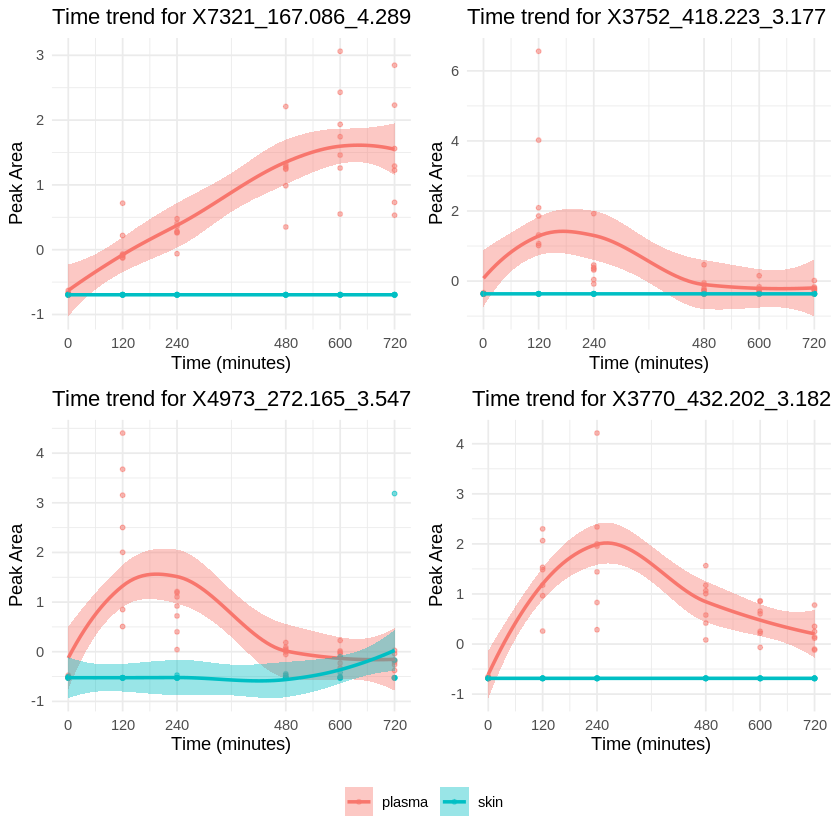

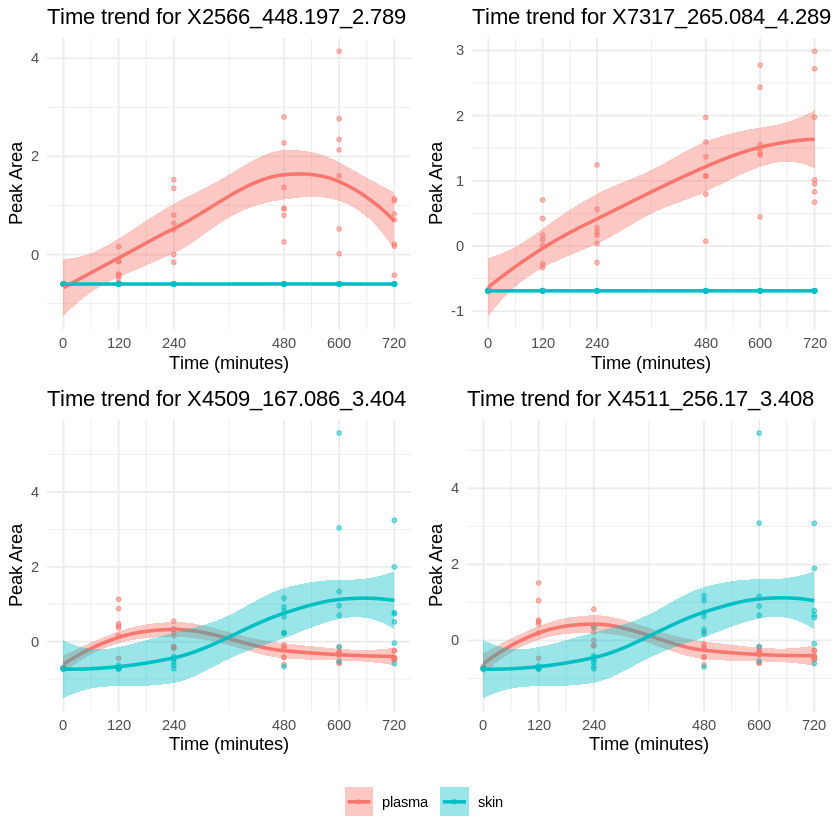

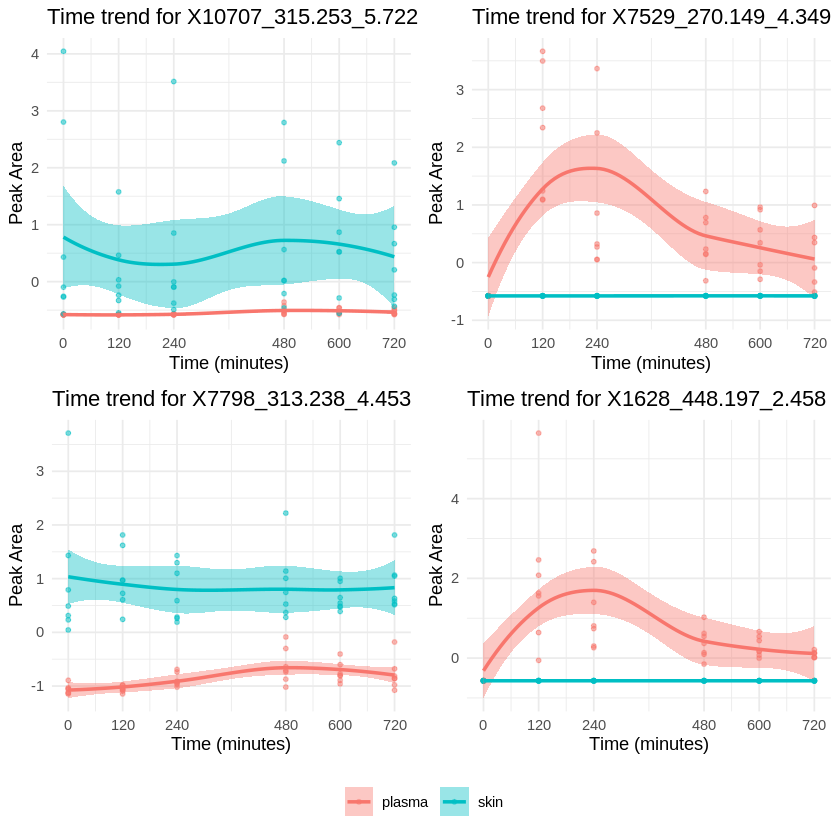

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


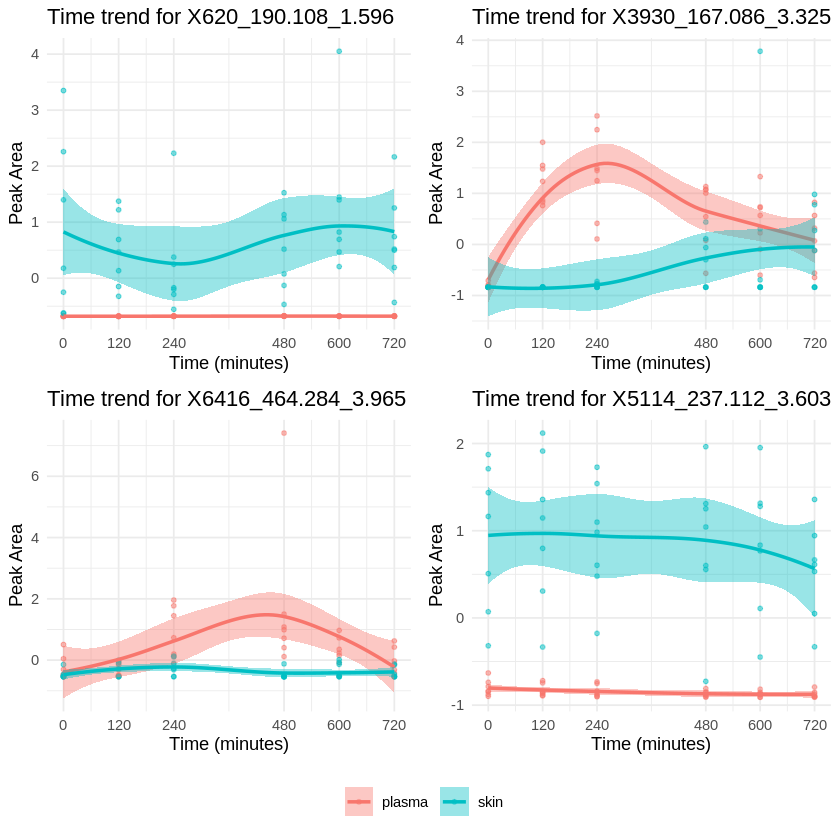

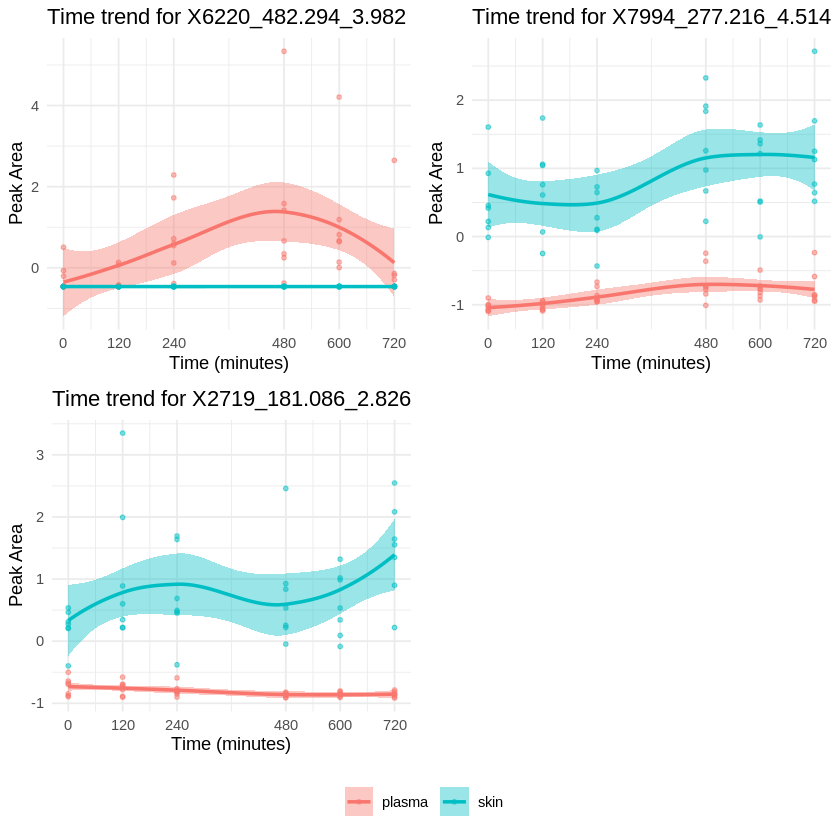

In [32]:
final_plots

**Export to pdf**

We export the plots to pdfs using ggsave. Since we export several plots, it can be done in a loop.

In [33]:
# Loop through each plot and save it to a PDF file
for (i in seq_along(final_plots)) {

  pdf_file <- paste0("timetrend_plot", i, ".pdf")

  # Save the plot to the PDF file using ggsave
  ggsave(filename = pdf_file, plot = final_plots[[i]], width = 10, height = 8)
}

# Heatmap

Here we will create a heatmap showing normalized and scaled relative abudances across all samples of metabolites that were found significantly differentially abundant in plasma across different timepoints. In addition we will retrieve compound superclasses for each metabolite from [CANOPUS](https://www.nature.com/articles/s41587-020-0740-8) and plot them on the heatmap.

load compound class annotation from CANOPUS

In [34]:
compclass_url <- 'https://raw.githubusercontent.com/ssi-dk/CD-MRG-metabolomics_summerschool_2023/main/data/sirius_output/Example/canopus_compound_summary.tsv'

In [35]:
compclass <- read.table(compclass_url, sep = '\t', comment.char = '', header = T, check.names = F, quote = '')

In [36]:
head(compclass)

,id,molecularFormula,adduct,precursorFormula,NPC#pathway,NPC#pathway Probability,NPC#superclass,NPC#superclass Probability,NPC#class,NPC#class Probability,⋯,ClassyFire#level 5,ClassyFire#level 5 Probability,ClassyFire#subclass,ClassyFire#subclass Probability,ClassyFire#class,ClassyFire#class Probability,ClassyFire#superclass,ClassyFire#superclass probability,ClassyFire#all classifications,featureId
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<int>
1,2_example_sirius_3847,C12H22O6,[M - H2O + H]+,C12H20O5,Fatty acids,0.9380314,Fatty Acids and Conjugates,0.52293098,Monoacylglycerols,0.438382089,⋯,Monoacylglycerols,0.9850627,Monoradylglycerols,0.9713010,Glycerolipids,0.97354490,Lipids and lipid-like molecules,0.9996331,Organic compounds; Lipids and lipid-like molecules; Alcohols and polyols; Glycerolipids; Fatty acids and conjugates; Organic acids and derivatives; Carboxylic acids and derivatives; Primary alcohols; Organooxygen compounds; Fatty acid esters; Dicarboxylic acids and derivatives; Carboxylic acid derivatives; Monoacylglycerols; Carboxylic acids; Carboxylic acid esters; 2-monoacylglycerols; Carbonyl compounds; Medium-chain fatty acids; Monoradylglycerols; Fatty Acyls; Organic oxides; Hydrocarbon derivatives; Organic oxygen compounds; Chemical entities,3847
2,3_example_sirius_10375,C33H53NO6,[M + H]+,C33H53NO6,Terpenoids,0.9700131,Pseudoalkaloids,0.34046406,Oleanane triterpenoids,0.125478968,⋯,,NA,,NA,,NA,Lipids and lipid-like molecules,0.9731670,Organic compounds; Organoheterocyclic compounds; Lipids and lipid-like molecules; Ketones; Alcohols and polyols; Piperidines; Organic acids and derivatives; Carboxylic acids and derivatives; Organonitrogen compounds; Primary alcohols; Organooxygen compounds; Carboxylic acid derivatives; Dialkyl ethers; Carbonyl compounds; Alkanolamines; Cyclic ketones; Organic oxides; Hydrocarbon derivatives; Organopnictogen compounds; Organic oxygen compounds; Organic nitrogen compounds; Chemical entities,10375
3,4_example_sirius_11797,C13H19O7P3S5,[M + H]+,C13H19O7P3S5,Fatty acids,0.7316329,Fatty acyls,0.01428358,Pyridine alkaloids,0.007987371,⋯,,NA,"1,4-dioxanes",0.5148861,Dioxanes,0.04442088,Organoheterocyclic compounds,0.8599285,"Organic compounds; Organoheterocyclic compounds; Organosulfur compounds; Organic acids and derivatives; Organooxygen compounds; 1,4-dioxanes; Sulfenyl compounds; Organic dithiophosphoric acids and derivatives; Dithiophosphate S-esters; Hydrocarbon derivatives; Dithiophosphate O-esters; Organic oxygen compounds; Chemical entities",11797
4,5_example_sirius_9065,C19H21NO3,[M + H]+,C19H21NO3,Alkaloids,0.9935048,Lysine alkaloids,0.98758650,Piperidine alkaloids,0.954749644,⋯,,NA,,NA,Benzodioxoles,0.97962040,Organoheterocyclic compounds,0.9999999,Organic compounds; Organoheterocyclic compounds; Styrenes; Piperidines; Ethers; Organic acids and derivatives; Carboxylic acids and derivatives; Organonitrogen compounds; Benzodioxoles; Organooxygen compounds; N-acylpiperidines; Carboxylic acid amides; Carboxylic acid derivatives; Acetals; Tertiary carboxylic acid amides; Carbonyl compounds; Benzene and substituted derivatives; Benzenoids; Organic oxides; Azacyclic compounds; Oxacyclic compounds; Hydrocarbon derivatives; Organopnictogen compounds; Organic oxygen compounds; Organic nitrogen compounds; Chemical entities,9065
5,6_example_sirius_5043,C19H20O7,[M + H]+,C19H20O7,Shikimates and Phenylpropanoids,0.3542166,Coumarins,0.12940928,Neolignans,0.111991525,⋯,,NA,,NA,Benzofurans,0.71078986,Organoheterocyclic compounds,0.9990615,Organic compounds; Organoheterocyclic compounds; Lactones; Alkyl aryl ethers; Phenols; Ethers; Organic acids and derivatives; Carboxylic acids and derivatives; Benzofurans; Organooxygen compounds; Carboxylic acid derivatives; Monocarboxylic acids and derivatives; Carboxylic acid esters; Acetals; Carbonyl compounds; Phenol ethers; Benzenoids; Organic oxides; Oxacyclic compounds; Hydroc

save feature Ids of all features that change significnatly over time in plasma in a vector

In [37]:
sig_features_plasma <- output_plasma$Metabolite[which(output_plasma$significant == 'Significant')]

create a feature table containing only features that change significantly over time in plasma

In [38]:
head(ft)

,X,X9002_150.063_4.963,X8808_150.596_4.822,X4094_151.039_3.305,X2584_151.039_2.783,X5788_151.075_3.796,X5122_151.075_3.587,X598_151.075_1.534,X1334_151.075_2.335,X649_151.075_1.623,⋯,X14653_1257.898_7.839,X7262_1259.35_4.281,X7209_1259.493_4.282,X7274_1259.638_4.269,X14656_1280.974_7.835,X14686_1310.987_8.01,X14690_1315.94_8.014,X14715_1369.027_8.219,X14730_1427.068_8.446,X7267_1469.075_4.282
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,bld_plt1_01_0_1.mzML,-0.8662273,-0.1965295,-0.8831492,-0.9477855,-0.9476314,-0.8827588,-0.7154505,-0.9454694,-0.6376003,⋯,-0.2132227,-0.3324730,-0.3033492,-0.2627040,-0.1705409,-0.2348066,-0.1877471,-0.1946509,-0.1756857,-0.1351521
2,bld_plt1_01_120_1.mzML,-0.8662301,-0.1973397,-0.8831492,-0.9491684,-0.9526049,-0.8824262,-0.7153539,-0.9458006,-0.6373360,⋯,-0.2122461,0.6185309,0.8157820,0.7605538,-0.1698431,-0.2347819,-0.1866834,-0.1943536,-0.1752368,0.5971932
3,bld_plt1_01_600_1.mzML,-0.8660764,-0.1976290,-0.8829391,-0.9503707,-0.9040143,-0.8799596,-0.7155218,-0.9447739,-0.6376531,⋯,-0.2122461,-0.1593889,-0.2756309,-0.1761300,-0.1709513,-0.2344228,-0.1870616,-0.1940105,-0.1746247,-0.2178643
4,bld_plt1_01_720_1.mzML,-0.8661837,-0.1971660,-0.8830250,-0.9500788,-0.8552687,-0.8825044,-0.7149378,-0.9445606,-0.6364170,⋯,-0.2135483,-0.3771775,-0.3600902,-0.3422496,-0.1704588,-0.2343237,-0.1870852,-0.1947881,-0.1753185,-0.2387165
5,bld_plt1_03_0_1.mzML,-0.8662304,-0.1961822,-0.8830441,-0.9492972,-0.5652369,-0.8825925,-0.7153917,-0.9452463,-0.6374285,⋯,-0.2121277,-0.3358358,-0.3152846,-0.3367929,-0.1707461,-0.2343485,-0.1873925,-0.1944451,-0.1762979,-0.2613841
6,bld_plt1_03_480_1.mzML,-0.8662304,-0.1954299,-0.8831205,-0.9490195,-0.5554838,-0.8826121,-0.7153833,-0.9458308,-0.6377721,⋯,-0.2129860,-0.3665276,-0.3596632,-0.3417601,-0.1693095,-0.2345466,-0.1876289,-0.1946738,-0.1745431,-0.2712681


In [39]:
rownames(ft) <- ft$X

In [40]:
ft_sig <- ft[,which(colnames(ft) %in% sig_features_plasma)]

In [41]:
head(ft_sig)

,X7321_167.086_4.289,X4509_167.086_3.404,X3930_167.086_3.325,X2719_181.086_2.826,X620_190.108_1.596,X5114_237.112_3.603,X4511_256.17_3.408,X7317_265.084_4.289,X7529_270.149_4.349,X4973_272.165_3.547,X7994_277.216_4.514,X7798_313.238_4.453,X10707_315.253_5.722,X3752_418.223_3.177,X3770_432.202_3.182,X2566_448.197_2.789,X1628_448.197_2.458,X6416_464.284_3.965,X6220_482.294_3.982
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bld_plt1_01_0_1.mzML,-0.69494658,-0.7195084,-0.8363480,-0.5004543,-0.6790041,-0.7384082,-0.7340543,-0.686809833,-0.5751956,-0.5257156,-1.0693858,-1.1248179,-0.5797646,-0.3645575,-0.68547656,-0.5998587,-0.569222753,0.04606497,-0.20686955
bld_plt1_01_120_1.mzML,-0.08890568,0.8809669,0.8704154,-0.5790207,-0.6794026,-0.7450664,1.0513257,0.004484534,3.4967691,2.0023702,-1.0749923,-1.1471908,-0.5798013,1.0149617,1.48501563,-0.1391494,1.558840619,-0.04545100,0.13288592
bld_plt1_01_600_1.mzML,1.74382781,-0.1459596,0.7370479,-0.8514735,-0.6787071,-0.8702056,-0.1662421,1.486366360,0.9611511,-0.2302256,-0.4920279,-0.4038593,-0.5586534,-0.2982310,0.25337803,0.5242423,-0.002680976,0.96938413,4.20767690
bld_plt1_01_720_1.mzML,2.23089601,-0.4827086,0.5660361,-0.8617827,-0.6740810,-0.8535264,-0.5024346,1.975939706,0.9917614,-0.1734458,-0.2357245,-0.1804416,-0.5680539,-0.2953949,0.14271761,0.2147609,0.010991034,0.42405833,2.64818787
bld_plt1_03_0_1.mzML,-0.68976038,-0.7153406,-0.8376268,-0.6752156,-0.6794488,-0.8764780,-0.7285626,-0.686539554,-0.5775919,-0.5107444,-1.0076399,-1.0508179,-0.5798222,-0.3640097,-0.68557198,-0.6010190,-0.569982811,-0.30211285,-0.06857557
bld_plt1_03_480_1.mzML,1.25884088,-0.4252993,1.0799471,-0.8672249,-0.6790378,-0.9065283,-0.4401112,1.071878952,0.1432138,0.1850861,-0.8407683,-0.8722793,-0.4260921,-0.2787183,0.08222041,0.2606441,0.368672800,0.11406376,1.58084113


bring metadata in same order as the feature table containing the significant feature ids. This is important for downstream analysis, where we assume that  rownames of the feature table are identifical to the filenames in the metadata.

In [42]:
md <- md[match(rownames(ft_sig),md$filename),]

In [43]:
identical(md$filename,rownames(ft_sig))

[1] TRUE

extract feature Ids from feature table

In [44]:
ft_sig_ids <- gsub('X','',sapply(strsplit(colnames(ft_sig), split = '_'),head,1))

In [45]:
ft_sig_ids

[1] "7321"  "4509"  "3930"  "2719"  "620"   "5114"  "4511"  "7317"  "7529" 
[10] "4973"  "7994"  "7798"  "10707" "3752"  "3770"  "2566"  "1628"  "6416" 
[19] "6220"

extract significant features from compound class annotation table from CANOPUS

In [46]:
compclass <- compclass[which(compclass$featureId %in% ft_sig_ids),]

In [47]:
dim(compclass)

[1] 16 22

for which features in the feature table do we not have annotation from CANOPUS?

In [48]:
ft_sig_ids[-which(ft_sig_ids %in% compclass$featureId)]

[1] "7317" "7529" "1628"

create a dataframe filled with 'no matches' for all features, that did not have a compound annotation with CANOPUS

In [49]:
n_matches <- as.data.frame(matrix(data = 'no matches',nrow = length(ft_sig_ids[-which(ft_sig_ids %in% compclass$featureId)]),
                      ncol = ncol(compclass), dimnames = list(c(),colnames(compclass))))

In [50]:
n_matches$featureId <- ft_sig_ids[-which(ft_sig_ids %in% compclass$featureId)]

In [51]:
n_matches

id,molecularFormula,adduct,precursorFormula,NPC#pathway,NPC#pathway Probability,NPC#superclass,NPC#superclass Probability,NPC#class,NPC#class Probability,⋯,ClassyFire#level 5,ClassyFire#level 5 Probability,ClassyFire#subclass,ClassyFire#subclass Probability,ClassyFire#class,ClassyFire#class Probability,ClassyFire#superclass,ClassyFire#superclass probability,ClassyFire#all classifications,featureId
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,⋯,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,7317
no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,⋯,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,7529
no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,⋯,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,no matches,1628


In [52]:
compclass <- rbind(compclass,n_matches)

create customized color legends for all annotated classes. **Make sure that there is a color defined for each class!** Pro tip: If you want to select your favorite color, find the correct *hex code*  [here](https://htmlcolorcodes.com/).

These are all classes

In [53]:
sort(unique(compclass$`ClassyFire#superclass`))

[1] "Benzenoids"                      "Lipids and lipid-like molecules"
[3] "no matches"                      "Organic acids and derivatives"  
[5] "Organoheterocyclic compounds"

Colors are defined as the list *col*

In [54]:
col <- list(Class = c( "Benzenoids" = "#FFC20A", 'Lipids and lipid-like molecules' = "#4B0092",
                      'Organic acids and derivatives' = "#994F00",'no matches' = 'grey', 'Organoheterocyclic compounds' = '#D35FB7')
            ,Sample =  c('plasma' = '#F8766D', 'skin' = '#00BFC4')
           )

In [55]:
identical(md$filename,rownames(ft_sig))

[1] TRUE

In [56]:
site_annot <- HeatmapAnnotation(Sample = md$ATTRIBUTE_Sample_Type, which = "row", width = unit(1.5, "cm")
                                 ,col = col, annotation_legend_param = list(title = "Site"))

In [57]:
identical(ft_sig_ids, compclass$featureId[match(ft_sig_ids,compclass$featureId)])

[1] TRUE

In [58]:
chem_annot <- HeatmapAnnotation(Class = compclass$`ClassyFire#superclass`[match(ft_sig_ids,compclass$featureId)]
                                ,col = col, annotation_legend_param = list(title = "Chemical class"))

order metadata and feature table according to sample type and time point

In [59]:
md <- md[order(md$ATTRIBUTE_Sample_Type,md$ATTRIBUTE_Timepoint_min),]

In [60]:
ft_sig <- ft_sig[match(md$filename,rownames(ft_sig)),]

In [61]:
identical(rownames(ft_sig),md$filename)

[1] TRUE

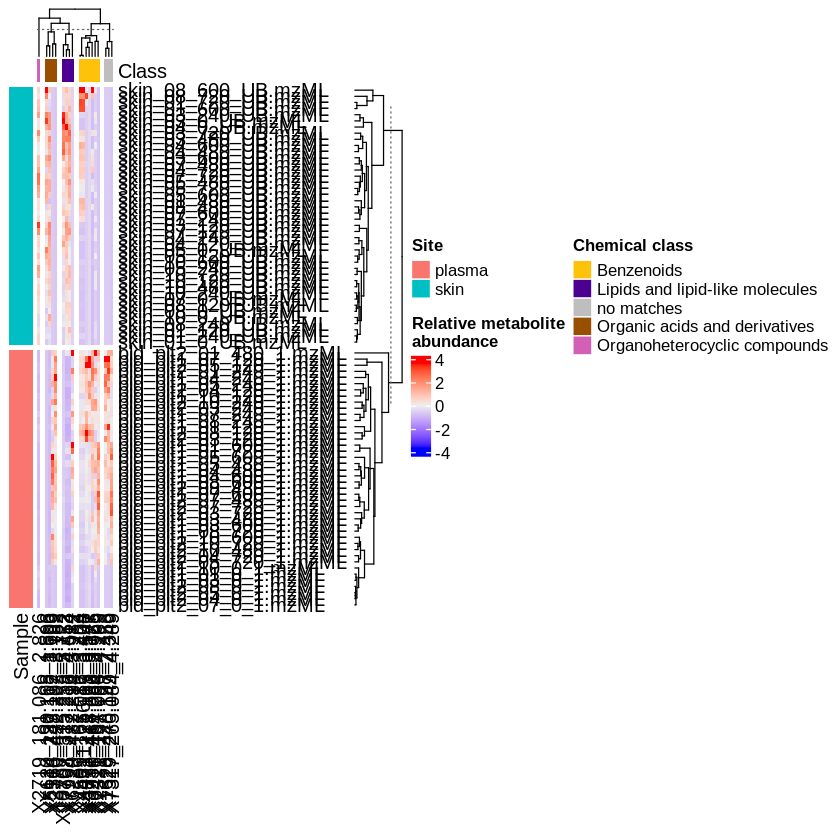

In [62]:
Heatmap(as.matrix(ft_sig),
       name = paste("Relative metabolite","abundance", sep = "\n"),
       clustering_distance_rows = 'euclidean',
       clustering_method_rows = 'complete',
       top_annotation = chem_annot,
       left_annotation = site_annot,
       split = md$ATTRIBUTE_Sample_Type,
       #row_labels = rep('',nrow(ft_sig)),
       #column_labels = rep('',ncol(ft_sig)),
       column_split = compclass$`ClassyFire#superclass`[match(ft_sig_ids,compclass$featureId)],
       row_dend_side = "right",
       cluster_row_slices = TRUE,
       cluster_columns = TRUE,
       cluster_rows = TRUE,
       column_title=NULL,
       row_title=NULL
       )

for better visualization, let's safe the heatmap as a .pdf file

In [63]:
pdf("AnnotatedHeatmap_Classes_Annotated_CANOPUS_samplenames.pdf", height = 14, width = 12)
Heatmap(as.matrix(ft_sig),
       name = paste("Relative metabolite","abundance", sep = "\n"),
       clustering_distance_rows = 'euclidean',
       clustering_method_rows = 'complete',
       top_annotation = chem_annot,
       left_annotation = site_annot,
       split = md$ATTRIBUTE_Sample_Type,
       #row_labels = rep('',nrow(ft_sig)),
       #column_labels = rep('',ncol(ft_sig)),
       column_split = compclass$`ClassyFire#superclass`[match(ft_sig_ids,compclass$featureId)],
       row_dend_side = "right",
       cluster_row_slices = TRUE,
       cluster_columns = TRUE,
       cluster_rows = FALSE,
       column_title=NULL,
       row_title=NULL
       )
dev.off()

png 
  2

we can also remove sample names for better visualization

In [64]:
pdf("AnnotatedHeatmap_Classes_Annotated_CANOPUS.pdf", height = 10, width = 8)
Heatmap(as.matrix(ft_sig),
       name = paste("Relative metabolite","abundance", sep = "\n"),
       clustering_distance_rows = 'euclidean',
       clustering_method_rows = 'complete',
       top_annotation = chem_annot,
       left_annotation = site_annot,
       split = md$ATTRIBUTE_Sample_Type,
       row_labels = rep('',nrow(ft_sig)),
       #column_labels = rep('',ncol(ft_sig)),
       column_split = compclass$`ClassyFire#superclass`[match(ft_sig_ids,compclass$featureId)],
       row_dend_side = "right",
       cluster_row_slices = TRUE,
       cluster_columns = TRUE,
       cluster_rows = FALSE,
       column_title=NULL,
       row_title=NULL
       )
dev.off()

png 
  2

In [65]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] ComplexHeatmap_2.16.0 ggrepel_0.9.3         cowplot_1.1.1        
[4] ggsci_3.0.0           ggplot2_3.4.3        

loaded via a namespace (and not attac